## **Problem**

Solving the two dimensional Schrodinger equation with an harmonic potential function

## **Method:**

Finite element method using a triangulation with 'hat' (pyramid) functions as basis functions

In [0]:
import numpy as np
import time
import scipy
from scipy import integrate
import matplotlib.pyplot as plt

## **Computing matrix elements**

In [0]:
def stiffness(i,j,k,l,h,order,fun):
    #outputs the matrix element corresponding to the overlapping of the 
    #domains with coordinates (i,j) and (k,l)
    #h: lattice spacing
    #order: 0 for computing the matrix element with the basis functions
    #       1 for computing the matrix element with the first derivative 
    #       of the basis functions
    #fun: function which multiplies the scalar product of the basis functions
    #     (potential)
  
    #x and y coordinates of the nearest neighbours to (i,j)
    zx = np.array([        
            [i,    i-1,   i,    i,    i+1,  i],
            [i-1,  i,     i-1,  i+1,  i,    i+1],
            [i,    i-1,   i,    i,    i+1,  i]
            ])
                        
    zy = np.array([        
            [j,    j,     j-1,  j,    j,    j+1],
            [j,    j,     j-1,  j,    j,    j+1],
            [j+1,  j-1,   j,    j-1,  j+1,  j]
            ])
    
    """
    We will distinguish between three cases:
        (k,l) == (i,j): 
            In this case the scalar product of the tent function with itself
            can be expressed as the sum of the integrals of the polynomials
            squared for each domain.
            
            Therefore, we will compute those integrals at each of the domains
            and sum them. 
            
            In order to compute the integral of the product of two polynomials
            at a given domain we need the coefficients of the polynomials and
            the limits of integration. Then the function dblquad will be use
            for computing the integrals numerically
            
        (k,l) is one of the nearest neighbours:
            In this case only two domains will contribute to the matrix element,
            so we compute the scalar product of the polynomials at each of the
            two domains by the same procedure as before, getting the coefficients
            and the limits of integration
            
        (k,l) is NOT one of the nearest neighbours:
            In this case the matrix element is zero                 
    """
    #condition for (k,l) not being a nearest neighbour to (i,j)
    if (((i-k)**2+(j-l)**2)>9/4)or((k,l)==(i-1,j+1))or((k,l)==(i+1,j-1)):
        S = 0
    #if (k,l) is one of the nearest neighbours to (i,j):    
    else:
        flag = 0
        if (k,l) == (i,j):
            domains = np.array([0,1,2,3,4,5])
            flag = 1
        
        elif (k,l) == (i,j+1):
            domains = np.array([0,5])
            
        elif (k,l) == (i-1,j):
            domains = np.array([1,0])
            
        elif (k,l) == (i-1,j-1):
            domains = np.array([2,1])
        
        elif (k,l) == (i,j-1):
            domains = np.array([3,2])
            
        elif (k,l) == (i+1,j):
            domains = np.array([4,3])
            
        elif (k,l) == (i+1,j+1):
            domains = np.array([5,4])
            
        #limits of integration in the x axis    
        xlims = {0:(i-1,i) , 1:(i-1,i) , 2:(i-1,i) , 3:(i,i+1) , 4:(i,i+1) , 5:(i,i+1) }
        #sum of the integrals on each domain
        S = 0
        for d in domains:   
            #coefficients of the polynomials for the tent function ij. Thanks
            #to the ordering used for the nodes of the triangles, the index ii of
            #the basis function for ij in the domain d will take the value d%3
            ii = d%3 
            #the coefficients are computed from the coordinates of the nodes 
            #of the triangle
            aij = -(zx[(ii+1)%3,d]*zy[(ii-1)%3,d]-zx[(ii-1)%3,d]*zy[(ii+1)%3,d])
            bij = -(zy[(ii+1)%3,d] - zy[(ii-1)%3,d])/h    
            cij = (zx[(ii+1)%3,d] - zx[(ii-1)%3,d])/h
            
            if flag == 1:
                #if (k,l) = (i,j), the polynomial corresponding to the tent function
                #(k,l) is the same as for (i,j), so their coefficients are equal                
                akl = aij
                bkl = bij
                ckl = cij
                
            else:
                #We have to get the index ii for the polynomial of the tent function 
                #centered on (k,l).
                c = domains[0]  
                if c == d:
                    ii = (d-1)%3 
                elif c == (d+1)%6:
                    ii = (d+1)%3
                      
                akl = -(zx[(ii+1)%3,d]*zy[(ii-1)%3,d]-zx[(ii-1)%3,d]*zy[(ii+1)%3,d])
                bkl = -(zy[(ii+1)%3,d] - zy[(ii-1)%3,d])/h    
                ckl = (zx[(ii+1)%3,d] - zx[(ii-1)%3,d])/h
            
            #limits of integration in x
            (A,B) = xlims[d]
            #due to the orientation of the triangles, we have to distinguish 
            #between odd and even domains in order to create the limits of 
            #integration for y
            if d%2 == 0:     
                #upper limit of integration in y
                yup = lambda x: h*zy[1,d] - h*zx[1,d]*(zy[2,d]-zy[1,d])/(zx[2,d]-zx[1,d]) + x*(zy[2,d]-zy[1,d])/(zx[2,d]-zx[1,d])
                #lower limit of integration in y
                ydn = lambda x: h*zy[0,d]                 
            else: 
                #upper limit of integration in y
                yup = lambda x: h*zy[0,d]               
                #lower limit of integration in y
                ydn = lambda x: h*zy[2,d] - h*zx[2,d]*(zy[1,d]-zy[2,d])/(zx[1,d]-zx[2,d]) + x*(zy[1,d]-zy[2,d])/(zx[1,d]-zx[2,d])
              
            #if order = 0 the functions corresponding to the nodes (i,j) and (k,l)
            #are constructed as polynomials using the coefficients previously calculated
            if order == 0:
                f_ij = lambda x,y: aij + bij*x + cij*y    
                f_kl = lambda x,y: akl + bkl*x + ckl*y    
            #if order = 1 the functions corresponding to the nodes (i,j) and (k,l)
            #are the gradients of the polynomials
            elif order == 1:
                f_ij = lambda x,y: np.array([bij,cij])   
                f_kl = lambda x,y: np.array([bkl,ckl])    
            #product of the functions f_ij and f_kl. This is the function
            #that will be integrated
            f_d = lambda y,x: np.dot(f_ij(x,y),f_kl(x,y))*fun(x,y)
            I1 = integrate.dblquad(f_d,A*h,B*h,ydn,yup)[0]
            S += I1
    return S

## **Assembling the stiffness and mass matrices**

In [0]:
def assembling_schrodinger(funV,N,L,order):
    #outputs the non zero elements of the stiffness and norm matrices
    #N: number of nodes
    #L: length of the domain
    #order: same as for the stiffness function
  
    #lattice spacing
    h = L/(N+1)
    #this traslation sets the domain centered at zero
    T = int(L/(2*h))
    
    d11 = np.zeros((N**2,))
    d21 = np.zeros((N**2-1,))
    d01 = np.zeros((N**2-1,))
    
    R11 = np.zeros((N**2,))
    R21 = np.zeros((N**2-1,))
    R01 = np.zeros((N**2-1,))
    
    for l in range(0,N**2):
        i = l%N
        j = l//N
        (i,j) = (i+1-T,j+1-T)
        
        d11[l] = stiffness(i,j,i,j,h,0,funV) + 4
        R11[l] = (h**2)/2

        if l<(N**2-1):
            if i == N-T:
                d21[l] = 0
                R21[l] = 0
            else:
                d21[l] = stiffness(i,j,i+1,j,h,0,funV) - 1
                R21[l] = (h**2)/12
                        
        if l>0:
            if i == 1-T:
                d01[l-1] = 0
                R01[l-1] = 0
            else:
                d01[l-1] = stiffness(i,j,i-1,j,h,0,funV) - 1
                R01[l-1] = (h**2)/12
               
    #loop for d12       
    d22 = np.zeros((N*(N-1)-1,))        
    d12 = np.zeros((N*(N-1),))
    
    R22 = np.zeros((N*(N-1)-1,))        
    R12 = np.zeros((N*(N-1),))
    
    for l in range(0,N*(N-1)):
        i = l%N
        j = l//N
        (i,j) = (i+1-T,j+1-T)
        d12[l] = stiffness(i,j,i,j+1,h,0,funV) - 1
        R12[l] = (h**2)/12
        
        if l<(N*(N-1)-1):
            if i == N-T:
                d22[l] = 0
                R22[l] = 0
            else:
                d22[l] = stiffness(i,j,i+1,j+1,h,0,funV)
                R22[l] = (h**2)/12
            
    #loop for d10
    d00 = np.zeros((N*(N-1)-1,))    
    d10 = np.zeros((N*(N-1),))
    
    R00 = np.zeros((N*(N-1)-1,))    
    R10 = np.zeros((N*(N-1),))
    
    for l in range(0,N*(N-1)):
        i = l%N
        j = l//N+1
        (i,j) = (i+1-T,j+1-T)
            
        d10[l] = stiffness(i,j,i,j-1,h,0,funV) - 1
        R10[l] = (h**2)/12
        
        if l>0:
            if i == 1-T:
                d00[l-1] = 0
                R00[l-1] = 0
            else:
                d00[l-1] = stiffness(i,j,i-1,j-1,h,0,funV)
                R00[l-1] = (h**2)/12
               
    Stiff = scipy.sparse.diags([d00,d10,d01,d11,d21,d12,d22],[-(N+1),-N,-1,0,1,N,N+1])
    NormM = scipy.sparse.diags([R00,R10,R01,R11,R21,R12,R22],[-(N+1),-N,-1,0,1,N,N+1])
   
    return Stiff, NormM     

## **Solving Schrodinger equation**

1-th eigenvalue: 2.0617845110728052


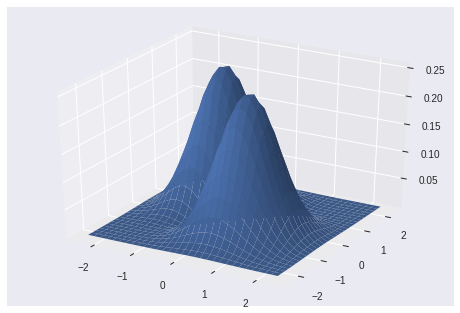

In [8]:
#potential function
def V(x,y):
    return x**2 + y**2

#scale of the grid (it might take a while if p>5)
p = 5
#number of nodes of the lattice
N = 2**p-1
#length of the domain in each dimension
L = 5
#lattice spacing
h = L/(N+1)

#assembly of the Stiffness and Normalization matrix
Stiff, NormM = assembling_schrodinger(V,N,L,0)  
Stiff = np.array(Stiff.todense())
NormM = np.array(NormM.todense())
#diagonalization
w,v = scipy.linalg.eigh(Stiff,NormM)
w = w/2
#domain of the plot
xv = np.linspace(-L/2+h,L/2-h,N)
yv = np.linspace(-L/2+h,L/2-h,N)
#order of the state that we want to plot (0 ground state, 1 first excited state...)
k = 1

#Eigenvalue
print(str(k)+'-th eigenvalue: '+str(w[k]))
#wave function
Phi = np.multiply(v[:,k],v[:,k])
Phi = np.reshape(Phi/(sum(Phi)*h**2),[N,N],'F')

#plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
x, y = np.meshgrid(xv, yv)
surf = ax.plot_surface(x, y, Phi)
plt.show()

## **Exact solution**

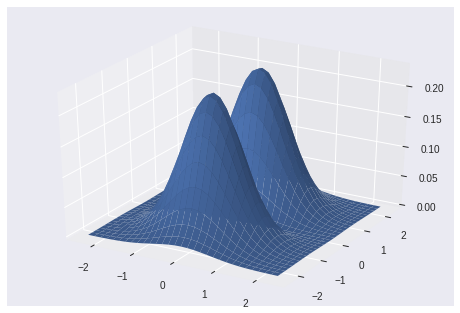

In [9]:
#analytical solution
from numpy import pi, exp

#quantum numbers for each dimension
m = 1
n = 0
#energy
E = m + n + 1

def phi(m,n,x,y):
    #normalization constant
    C = 1/np.sqrt(2**(m+n)*scipy.math.factorial(n)*scipy.math.factorial(m)*pi)
    #Hermite polynomials
    Hn = scipy.special.hermite(n)
    Hm = scipy.special.hermite(m)
    return (C*exp(-(x**2+y**2)/2)*Hn(x)*Hm(y))**2

p = 5
#number of nodes
N = 2**p - 1
#length of the domain
L = 5
#lattice spacing
h = L/(N+1)
#grid
xv = np.linspace(-L/2+h,L/2-h,N)
yv = np.linspace(-L/2+h,L/2-h,N)
x,y = np.meshgrid(xv,yv)

#computing the wavefunction
wave_f = phi(m,n,x,y)

#plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, wave_f)
plt.show()